In [1]:
import time
from time import perf_counter

# Data processing.
import json
import numpy as np
import pandas as pd

# Q6: For loading multiple CSVs into a single (pandas) dataframe.
import glob
import os

# Plotting.
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_style('whitegrid')

# "Vanilla" python parallelism.
import multiprocessing

# Scalable data analytics: dask.
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import graphviz

# Unused: scalable data analytics using Spark.
#from pyspark.sql import SparkSession

# For GC large pandas dataframes after use.
import gc

# Ignore warnings.
import warnings
warnings.simplefilter("ignore")

import random
random.seed(1)

# Q2

Using the same timeseries dask dataframe from in-class portion, compute a rolling 5m average y value for data only from January 2018. How does the min and the max runtimes you observed using dask compare to what you observed when using pandas? (35 pts)

### Pandas

In [15]:
%%time

dti = pd.date_range(start='2018-01-01',
                    end='2018-01-31',
                    freq='1s')
df = pd.DataFrame(index=dti, columns=['x', 'y', 'int'])
df['x'] = np.random.randint(0,1000, size=len(df))/1000
df['y'] = np.random.randint(0,1000, size=len(df))/1000
df['int'] = np.random.randint(0,1000, size=len(df))

CPU times: user 1.5 s, sys: 199 ms, total: 1.7 s
Wall time: 1.61 s


In [17]:
times = []
for i in range(50):
    timeStart = perf_counter()
    avg = df['y'].rolling('5min').mean()
    timeDelta = (perf_counter()-timeStart)*1000
    times.append(timeDelta)

print("Min Time:", min(times), "ms")
print("Max Time:", max(times), "ms")


Min Time: 83.54770000005374 ms
Max Time: 134.52922100009346 ms


### Dask

In [18]:
%%time

dd_df = dd.demo.make_timeseries(start='2018-01-01',
                                end='2018-01-31',
                                dtypes={'x': float, 'y': float, 'int': int},
                                freq='1s',
                                partition_freq='24h')

CPU times: user 17.4 ms, sys: 16.1 ms, total: 33.6 ms
Wall time: 39.6 ms


In [23]:
cores = [4, 2, 1]
cluster = LocalCluster(ip=None, n_workers=4, processes=True)
client = Client(cluster)

avgTime = []
for workers in cores:
    print(workers, "Core")
    cluster.scale(workers)
    time.sleep(1)
    
    times = []
    for i in range(50):
        timeStart = perf_counter()
        avg = dd_df['y'].rolling('5min').mean()
        timeDelta = (perf_counter()-timeStart)*1000
        times.append(timeDelta)

    avgTime.append(sum(times)/len(times))
    print("Min Time:", min(times), "ms")
    print("Max Time:", max(times), "ms")
    print()

4 Core
Min Time: 6.777168000098754 ms
Max Time: 19.38227599998754 ms

2 Core
Min Time: 7.018462000132786 ms
Max Time: 63.5250420000375 ms

1 Core
Min Time: 7.081581999955233 ms
Max Time: 73.36188800013588 ms



Text(0, 0.5, 'Time (ms)')

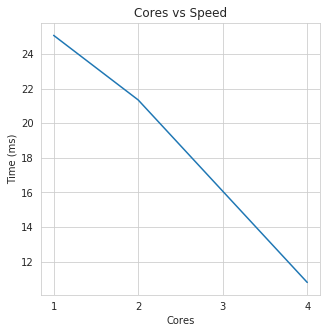

In [33]:
plt.figure(figsize=(5,5))
plt.title("Cores vs Speed")
plt.plot([4, 2, 1], avgTime)
plt.xticks(range(1, 5))
plt.xlabel('Cores')
plt.ylabel("Time (ms)")

# Q3

Using the same mybinder.org JSON data from in-class portion: who were the top 2 providers of notebooks in August 2019, and how many total runs did each of the 2 have?

In [28]:
urls = (db.read_text('https://archive.analytics.mybinder.org/index.jsonl')
          .map(json.loads).pluck('name').compute())
urls = ['https://archive.analytics.mybinder.org/' + u for u in urls]
notebook_runs = db.read_text(urls).map(json.loads)

### Dask

In [29]:
cores = [4, 2, 1]
cluster = LocalCluster(ip=None, n_workers=4, processes=True)
client = Client(cluster)

rTimes = []
for workers in cores:
    print(workers, "Core")
    cluster.scale(workers)
    time.sleep(1)

    t1_start = perf_counter()
    dd_df = notebook_runs.to_dataframe()
    dd_df = dd_df[(dd_df['timestamp'].str.startswith('2019-08'))]
    top_runs = (dd_df.provider.value_counts()
                     .nlargest(2)
                     .compute())
    t1_stop = perf_counter()
    
    rTime = ((t1_stop - t1_start)*1000)
    rTimes.append(rTime)
    print('\nTop-2 using dask dataframe (ms): %s\n' % rTime)
    print('results:')
    print(top_runs)
    print()

4 Core

Top-2 using dask dataframe (ms): 147760.25749400014

results:
GitHub    374145
Gist        5894
Name: provider, dtype: int64

2 Core


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60520 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60524 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60526 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60528 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60532 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60534 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60536 remote=tcp://127.0.0.1:42821>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:60538 remote=tcp://127.0.0.1:42821>
distribu


Top-2 using dask dataframe (ms): 235476.32858299994

results:
GitHub    374145
Gist        5894
Name: provider, dtype: int64

1 Core

Top-2 using dask dataframe (ms): 359509.18714399997

results:
GitHub    374145
Gist        5894
Name: provider, dtype: int64



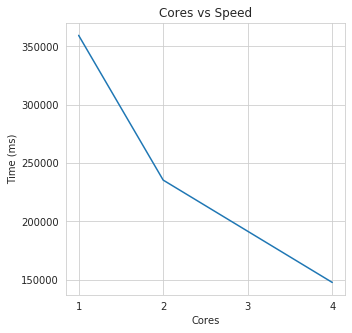

In [36]:
plt.figure(figsize=(5,5))
plt.title("Cores vs Speed")
plt.plot([4, 2, 1], rTimes)
plt.xticks(range(1, 5))
plt.xlabel('Cores')
plt.ylabel("Time (ms)")
plt.show()

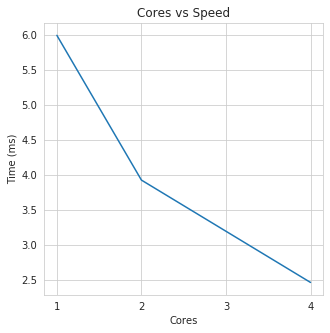

In [35]:
plt.figure(figsize=(5,5))
plt.title("Cores vs Speed")
plt.plot([4, 2, 1], np.array(rTimes)/1000/60)
plt.xticks(range(1, 5))
plt.xlabel('Cores')
plt.ylabel("Time (ms)")
plt.show()